In [1]:
### import packages
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [2]:
### import data
data = pd.read_csv('test_data.txt')

## Clean Data

In [3]:
### format the time by strip and split the strings
data[['shift_date','shift_end']] = data.shiftid.str.strip().str.split("to",expand=True,)
data[['shift_date','shift_start']] = data.shift_date.str.strip().str.split(" ", 1,expand=True,)
data['shift_start'] = data['shift_start'].apply(lambda x: '12 p.m.'\
                                                if x == ('noon') else x)
data['shift_start'] = data['shift_start'].apply(lambda x: str(x.split(' ')[0] + ':00:00'\
                                                if x.endswith('a.m.') or (x == '12 p.m.') \
                                                else str(int(x.split(' ')[0])+12)+':00:00'))
data['shift_end'] = data['shift_end'].apply(lambda x: '12 p.m.'\
                                                if x.strip() == ('noon') else x)
data['shift_end'] = data['shift_end'].apply(lambda x: str(x.strip().split(' ')[0] + ':00:00'\
                                                if x.endswith('a.m.') or (x == '12 p.m.') \
                                                else str(int(x.strip().split(' ')[0])+12)+':00:00'))
data['shift_start'] = data[['shift_date', 'shift_start']].agg(' '.join, axis=1)
data['shift_end'] = data[['shift_date', 'shift_end']].agg(' '.join, axis=1)

### convert string type to datetime type
data['ed_tc'] = pd.to_datetime(data['ed_tc'])
data['dcord_tc'] = pd.to_datetime(data['dcord_tc'])
data['shift_date'] = pd.to_datetime(data['shift_date'])
data['shift_start'] = pd.to_datetime(data['shift_start'])
data['shift_end'] = pd.to_datetime(data['shift_end'])

### Add one day to shift end time that is before the shift end time
### because there is no shift end date in the original data
mask = data['shift_end'] < data['shift_start']
data.loc[mask, 'shift_end'] = data.loc[mask, 'shift_end'] + pd.DateOffset(1)
data['shift_len'] = data['shift_end'] - data['shift_start']
data['stay_len'] = data['dcord_tc'] - data['ed_tc']

In [4]:
data

,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num,shift_date,shift_end,shift_start,shift_len,stay_len
0,1982-05-17 14:47:00,1982-05-18 10:49:00,0.408644,17may1982 1 p.m. to 10 p.m.,Andrew,1,1982-05-17,1982-05-17 22:00:00,1982-05-17 13:00:00,09:00:00,20:02:00
1,1982-07-14 17:49:00,1982-07-14 18:51:00,0.338402,14jul1982 1 p.m. to 10 p.m.,Andrew,2,1982-07-14,1982-07-14 22:00:00,1982-07-14 13:00:00,09:00:00,01:02:00
2,1982-06-30 13:02:00,1982-06-30 14:09:00,0.309749,30jun1982 11 a.m. to 8 p.m.,Andrew,3,1982-06-30,1982-06-30 20:00:00,1982-06-30 11:00:00,09:00:00,01:07:00
3,1982-05-21 10:51:00,1982-05-22 10:11:00,0.592807,21may1982 6 a.m. to 4 p.m.,Andrew,4,1982-05-21,1982-05-21 16:00:00,1982-05-21 06:00:00,10:00:00,23:20:00
4,1982-05-21 08:18:00,1982-05-21 09:02:00,1.174824,21may1982 6 a.m. to 4 p.m.,Andrew,5,1982-05-21,1982-05-21 16:00:00,1982-05-21 06:00:00,10:00:00,00:44:00
...,...,...,...,...,...,...,...,...,...,...,...
8826,1982-06-24 13:36:00,1982-06-24 15:11:00,1.540322,24jun1982 1 p.m. to 10 p.m.,Teresa,8827,1982-06-24,1982-06-24 22:00:00,1982-06-24 13:00:00,09:00:00,01:35:00
8827,1982-06-25 21:33:00,1982-06-26 04:42:00,1.002466,25jun1982 7 p.m. to 4 a.m.,Teresa,8828,1982-06-25,1982-06-26 04:00:00,1982-06-25 19:00:00,09:00:00,07:09:00
8828,1982-06-24 17:46:00,1982-06-24 20:39:00,1.221502,24jun1982 1 p.m. to 10 p.m.,Teresa,8829,1982-06-24,1982-06-24 22:00:00,1982-06-24 13:00:00,09:00:00,02:53:00
8829,1982-05-28 07:50:00,1982-05-28 09:38:00,0.994581,28may1982 6 a.m. to 4 p.m.,Teresa,8830,1982-05-28,1982-05-28 16:00:00,1982-05-28 06:00:00,10:00:00,01:48:00


## Q0

### Errors

In [5]:
### arrival time later than the shift end time
data[data['ed_tc']>data['shift_end']]

,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num,shift_date,shift_end,shift_start,shift_len,stay_len


In [6]:
### discharged time earlier than the shift start time
data[data['dcord_tc']<data['shift_start']]

,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num,shift_date,shift_end,shift_start,shift_len,stay_len
406,1982-06-24 13:14:00,1982-06-24 17:32:00,1.240981,24jun1982 7 p.m. to 4 a.m.,John,407,1982-06-24,1982-06-25 04:00:00,1982-06-24 19:00:00,09:00:00,04:18:00
3659,1982-06-26 11:07:00,1982-06-26 11:39:00,1.221203,26jun1982 noon to 10 p.m.,Warren,3660,1982-06-26,1982-06-26 22:00:00,1982-06-26 12:00:00,10:00:00,00:32:00
3684,1982-05-26 02:37:00,1982-05-26 02:46:00,1.480152,26may1982 3 a.m. to noon,Warren,3685,1982-05-26,1982-05-26 12:00:00,1982-05-26 03:00:00,09:00:00,00:09:00
4816,1982-05-18 06:55:00,1982-05-18 07:59:00,0.221509,18may1982 8 a.m. to 5 p.m.,Whoopi,4817,1982-05-18,1982-05-18 17:00:00,1982-05-18 08:00:00,09:00:00,01:04:00


In [7]:
## arrival time later than the discharged time
data[data['dcord_tc']<data['ed_tc']]

,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num,shift_date,shift_end,shift_start,shift_len,stay_len
3269,1982-06-23 15:43:00,1982-06-23 15:25:00,0.863325,23jun1982 1 p.m. to 10 p.m.,Diana,3270,1982-06-23,1982-06-23 22:00:00,1982-06-23 13:00:00,09:00:00,-1 days +23:42:00
7910,1982-05-23 14:59:00,1982-05-23 13:59:00,1.136199,23may1982 8 a.m. to 5 p.m.,Ingrid,7911,1982-05-23,1982-05-23 17:00:00,1982-05-23 08:00:00,09:00:00,-1 days +23:00:00
8504,1982-07-14 18:50:00,1982-07-14 17:01:00,1.027696,14jul1982 1 p.m. to 10 p.m.,Oprah,8505,1982-07-14,1982-07-14 22:00:00,1982-07-14 13:00:00,09:00:00,-1 days +22:11:00


In [8]:
### shift end time earlier than the shift start time
data[data['shift_end']<data['shift_start']]

,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num,shift_date,shift_end,shift_start,shift_len,stay_len


In [9]:
### Drop error entries
data.drop(data[data['dcord_tc']<data['shift_start']].index, inplace=True)
data.drop(data[data['dcord_tc']<data['ed_tc']].index, inplace=True)

In [10]:
data

,ed_tc,dcord_tc,xb_lntdc,shiftid,phys_name,visit_num,shift_date,shift_end,shift_start,shift_len,stay_len
0,1982-05-17 14:47:00,1982-05-18 10:49:00,0.408644,17may1982 1 p.m. to 10 p.m.,Andrew,1,1982-05-17,1982-05-17 22:00:00,1982-05-17 13:00:00,09:00:00,20:02:00
1,1982-07-14 17:49:00,1982-07-14 18:51:00,0.338402,14jul1982 1 p.m. to 10 p.m.,Andrew,2,1982-07-14,1982-07-14 22:00:00,1982-07-14 13:00:00,09:00:00,01:02:00
2,1982-06-30 13:02:00,1982-06-30 14:09:00,0.309749,30jun1982 11 a.m. to 8 p.m.,Andrew,3,1982-06-30,1982-06-30 20:00:00,1982-06-30 11:00:00,09:00:00,01:07:00
3,1982-05-21 10:51:00,1982-05-22 10:11:00,0.592807,21may1982 6 a.m. to 4 p.m.,Andrew,4,1982-05-21,1982-05-21 16:00:00,1982-05-21 06:00:00,10:00:00,23:20:00
4,1982-05-21 08:18:00,1982-05-21 09:02:00,1.174824,21may1982 6 a.m. to 4 p.m.,Andrew,5,1982-05-21,1982-05-21 16:00:00,1982-05-21 06:00:00,10:00:00,00:44:00
...,...,...,...,...,...,...,...,...,...,...,...
8826,1982-06-24 13:36:00,1982-06-24 15:11:00,1.540322,24jun1982 1 p.m. to 10 p.m.,Teresa,8827,1982-06-24,1982-06-24 22:00:00,1982-06-24 13:00:00,09:00:00,01:35:00
8827,1982-06-25 21:33:00,1982-06-26 04:42:00,1.002466,25jun1982 7 p.m. to 4 a.m.,Teresa,8828,1982-06-25,1982-06-26 04:00:00,1982-06-25 19:00:00,09:00:00,07:09:00
8828,1982-06-24 17:46:00,1982-06-24 20:39:00,1.221502,24jun1982 1 p.m. to 10 p.m.,Teresa,8829,1982-06-24,1982-06-24 22:00:00,1982-06-24 13:00:00,09:00:00,02:53:00
8829,1982-05-28 07:50:00,1982-05-28 09:38:00,0.994581,28may1982 6 a.m. to 4 p.m.,Teresa,8830,1982-05-28,1982-05-28 16:00:00,1982-05-28 06:00:00,10:00:00,01:48:00


### Description

In [41]:
### Summary of shifts per physician
data0 = data[['phys_name','shiftid']]
data0.drop_duplicates(inplace=True)
data0['count'] = data0.groupby(['phys_name'])['shiftid'].transform('count')
data0.drop(columns=['shiftid'],inplace=True)
data0.drop_duplicates(inplace=True)

### Summary of visits per physician
data1 = data[['phys_name','visit_num']]
data1['count'] = data1.groupby(['phys_name'])['visit_num'].transform('count')
data1.drop(columns=['visit_num'],inplace=True)
data1.drop_duplicates(inplace=True)

In [12]:
print('There are {} of visits'.format(data.shape[0]))
print('There are {} of physicians'.format(len(data['phys_name'].unique())))
print('The data covers the stays from {} to {}'.format(str(min(data['ed_tc'])).split(' ')[0],\
                                                       str(max(data['dcord_tc'])).split(' ')[0] ))
print('The data covers the shifts from {} to {}'.format(str(min(data['shift_start'])).split(' ')[0],\
                                                        str(max(data['shift_end'])).split(' ')[0] ))
print('The min, max, mean, median and standard deviation of the stay are {}, {}, {}, {}, and {}'.format(data['stay_len'].min(),\
                                                                                                data['stay_len'].max(),\
                                                                                                data['stay_len'].mean(),\
                                                                                                data['stay_len'].median(),\
                                                                                                data['stay_len'].std()))

print('The min, max, mean, median and standard deviation of the shift are {}, {}, {},{}, and {}'.format(data['shift_len'].min(),\
                                                                                                 data['shift_len'].max(),\
                                                                                                 data['shift_len'].mean(),\
                                                                                                 data['shift_len'].median(),\
                                                                                                 data['shift_len'].std()))

print('The min, max, mean, median and standard deviation of the severity level are {}, {}, {}, {}, and {}'.format(data['xb_lntdc'].min(),\
                                                                                                          data['xb_lntdc'].max(),\
                                                                                                          data['xb_lntdc'].mean(),\
                                                                                                          data['xb_lntdc'].median(),\
                                                                                                          data['xb_lntdc'].std()))

print('The min, max, mean, median and standard deviation of the shifts per physician are {}, {}, {}, {}, and {}'.format(data0['count'].min(),\
                                                                                                          data0['count'].max(),\
                                                                                                          data0['count'].mean(),\
                                                                                                          data0['count'].median(),\
                                                                                                          data0['count'].std()))

print('The min, max, mean, median and standard deviation of the visits per physician are {}, {}, {}, {}, and {}'.format(data1['count'].min(),\
                                                                                                          data1['count'].max(),\
                                                                                                          data1['count'].mean(),\
                                                                                                          data1['count'].median(),\
                                                                                                          data1['count'].std()))

There are 8824 of visits
There are 43 of physicians
The data covers the stays from 1982-05-15 to 1982-07-16
The data covers the shifts from 1982-05-15 to 1982-07-16
The min, max, mean, median and standard deviation of the stay are 0 days 00:00:00, 1 days 12:51:00, 0 days 04:02:38.560743, 0 days 02:51:00, and 0 days 04:13:03.007328
The min, max, mean, median and standard deviation of the shift are 0 days 02:00:00, 0 days 10:00:00, 0 days 09:06:10.444242,0 days 09:00:00, and 0 days 00:21:34.358322
The min, max, mean, median and standard deviation of the severity level are -0.2758868, 2.124072, 1.1212310564483228, 1.202872, and 0.3818074528405659
The min, max, mean, median and standard deviation of the shifts per physician are 2, 23, 12.325581395348838, 12.0, and 5.055505863401181
The min, max, mean, median and standard deviation of the visits per physician are 2, 416, 205.2093023255814, 188.0, and 92.71398880929583


## Q1

In [13]:
print("The ratio of patients who arrive before shift start: ", data[data['ed_tc'] < data['shift_start']].shape[0]/data.shape[0])
print("The ratio of patients who are discharged after shift ends: " ,data[data['shift_end'] < data['dcord_tc']].shape[0]/data.shape[0])

The ratio of patients who arrive before shift start:  0.07320942883046237
The ratio of patients who are discharged after shift ends:  0.18982320942883046


## Q2

In [15]:
data['ed_hour'] = data['ed_tc'].apply(lambda x: x.hour)

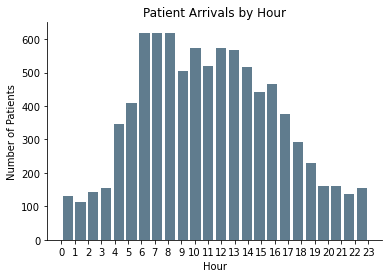

In [21]:

data['ed_hour'].plot.hist(grid=False, bins=24, rwidth=0.8,
                   color='#607c8e')
plt.title('Patient Arrivals by Hour')
plt.xlabel('Hour')
plt.ylabel('Number of Patients')
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticks(np.arange(0, 24, 1))
plt.savefig('q2_1.png', dpi=600, format='png')
plt.show()

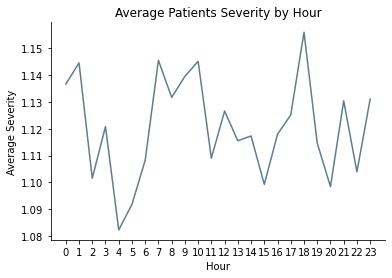

In [22]:
data['avg_xb_lntdc'] = data.groupby(['ed_hour'])['xb_lntdc'].transform('mean')
data0 = data[['ed_hour','avg_xb_lntdc']].drop_duplicates()
data0 = data0.sort_values(by=['ed_hour'], ascending=True)
data0.reset_index(drop=True,inplace=True)

data0.plot.line(x='ed_hour', y='avg_xb_lntdc', color='#607c8e')
plt.title('Average Patients Severity by Hour')
plt.xlabel('Hour')
plt.ylabel('Average Severity')
ax = plt.gca()
ax.get_legend().remove()
ax.set_xticks(np.arange(0, 24, 1))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('q2_2.png', dpi=600, format='png')
plt.show()

# Q3

In [23]:
data3 = data[['phys_name','shift_start','shift_end']].drop_duplicates()
data3['length'] = data3['shift_end'] - data3['shift_start']
data3['length'] = data3['length'].apply(lambda x: x.seconds/3600)

In [24]:
census = pd.DataFrame(columns = ['phys_name','shift_start', 'shift_end','index','time'])
### Generate dataframe of phys_name, shift, time, and index
### to be merged with number of visits
for index, row in data3.iterrows():
    for i in range (int(-data3.loc[index, 'length']),4,1):
        census = census.append({'phys_name': data3.loc[index, 'phys_name'],\
                                'shift_start': data3.loc[index, 'shift_start'],\
                                'shift_end': data3.loc[index, 'shift_end'],
                                'index': i,
                                'time':data3.loc[index, 'shift_end']+ pd.DateOffset(hours=i)}, ignore_index = True) 

In [25]:
census

,phys_name,shift_start,shift_end,index,time
0,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-9,1982-05-17 13:00:00
1,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-8,1982-05-17 14:00:00
2,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-7,1982-05-17 15:00:00
3,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-6,1982-05-17 16:00:00
4,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-5,1982-05-17 17:00:00
...,...,...,...,...,...
6924,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,-1,1982-05-28 15:00:00
6925,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,0,1982-05-28 16:00:00
6926,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,1,1982-05-28 17:00:00
6927,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,2,1982-05-28 18:00:00


In [26]:
def gen_census(census,data,type_):
    '''
    generate the census dataframe for different types
    input:
        census: the dataframe of index
        data: the original dataframe
        type_: the type of census ('exact', 'lower', 'upper') 
    output:
        output: merged census dataframe
    '''
    
    d = data[['phys_name','ed_tc','dcord_tc']].drop_duplicates()
    ### set visit begin the hour after arrival for the lower bound 
    if type_ == 'lower':
        d['ed_tc'] = d['ed_tc'].apply(lambda x: x.replace(minute=0, second=0)+pd.DateOffset(hours=1))
    ### set visit begin the hour before arrival for the upper bound and exact
    else:
        d['ed_tc'] = d['ed_tc'].apply(lambda x: x.replace(minute=0, second=0))
    ### set visit end the hour after discharge for the upper bound 
    if type_ == 'upper':
        d['dcord_tc'] = d['dcord_tc'].apply(lambda x: x.replace(minute=0, second=0)+pd.DateOffset(hours=1))
    ### set visit begin the hour before arrival for the upper bound and exact
    else:
        d['dcord_tc'] = d['dcord_tc'].apply(lambda x: x.replace(minute=0, second=0))

    d['hours'] = d['dcord_tc'] - d['ed_tc']
    d['hours']  = d['hours'].apply(lambda x: int(x.seconds/3600))
    ### Generate dataframe of phys_name, time and num of visits
    s = pd.DataFrame(columns = ['phys_name','time'])
    for index, row in d.iterrows():
        for i in range (0,d.loc[index,'hours']+1,1):
            s = s.append({'phys_name': d.loc[index, 'phys_name'],\
                          'time': d.loc[index, 'ed_tc']+ pd.DateOffset(hours=i)}, ignore_index = True) 
        
    s['count'] = s.groupby(['phys_name','time'])['time'].transform('count')
    s.drop_duplicates(inplace=True)
    output = pd.merge(census,s,how='left',on=['phys_name','time'])
    
    return output

In [27]:
def plot_census(census,type_):
    '''
    generate the line plot of average numeber of visits
    by hour index for different types of census data
    input:
        census: the census dataframe
        type_: the type of census ('exact', 'lower', 'upper') 
    '''
    c =census.copy()
    c['mean_count'] = c.groupby(['index'])['count'].transform('mean')
    c = c[['index','mean_count']].drop_duplicates().sort_values(by=['index'], ascending=True)
    c.plot.line(x='index', y='mean_count', color='#607c8e')
    plt.title(type_.split('_')[0].capitalize() +' '+type_.split('_')[1].capitalize())
    plt.xlabel('Hour Index')
    plt.ylabel('Number of Patients')
    ax = plt.gca()
    ax.get_legend().remove()
    ax.set_xticks(np.arange(-10, 4, 1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    plt.savefig('q3_'+type_+'.png', dpi=600, format='png')
    plt.show()

### Exact Census

In [28]:
exact_census = gen_census(census,data,'exact')
exact_census.to_csv(r'exact_census.csv')
exact_census

,phys_name,shift_start,shift_end,index,time,count
0,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-9,1982-05-17 13:00:00,6.0
1,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-8,1982-05-17 14:00:00,8.0
2,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-7,1982-05-17 15:00:00,8.0
3,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-6,1982-05-17 16:00:00,8.0
4,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-5,1982-05-17 17:00:00,9.0
...,...,...,...,...,...,...
6924,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,-1,1982-05-28 15:00:00,2.0
6925,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,0,1982-05-28 16:00:00,2.0
6926,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,1,1982-05-28 17:00:00,2.0
6927,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,2,1982-05-28 18:00:00,2.0


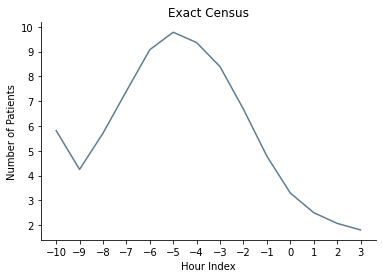

In [29]:
plot_census(exact_census,'exact_census')

### Lower bound census

In [30]:
lower_census = gen_census(census,data,'lower')
lower_census.to_csv(r'lower_census.csv')
lower_census

,phys_name,shift_start,shift_end,index,time,count
0,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-9,1982-05-17 13:00:00,3.0
1,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-8,1982-05-17 14:00:00,6.0
2,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-7,1982-05-17 15:00:00,5.0
3,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-6,1982-05-17 16:00:00,6.0
4,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-5,1982-05-17 17:00:00,8.0
...,...,...,...,...,...,...
6924,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,-1,1982-05-28 15:00:00,5.0
6925,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,0,1982-05-28 16:00:00,5.0
6926,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,1,1982-05-28 17:00:00,5.0
6927,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,2,1982-05-28 18:00:00,5.0


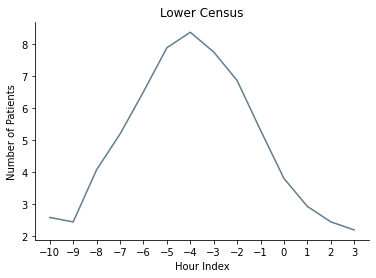

In [31]:
plot_census(lower_census,'lower_census')

### Upper bound census

In [32]:
upper_census = gen_census(census,data,'upper')
upper_census.to_csv(r'upper_census.csv')
upper_census

,phys_name,shift_start,shift_end,index,time,count
0,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-9,1982-05-17 13:00:00,6.0
1,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-8,1982-05-17 14:00:00,8.0
2,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-7,1982-05-17 15:00:00,11.0
3,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-6,1982-05-17 16:00:00,11.0
4,Andrew,1982-05-17 13:00:00,1982-05-17 22:00:00,-5,1982-05-17 17:00:00,10.0
...,...,...,...,...,...,...
6924,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,-1,1982-05-28 15:00:00,2.0
6925,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,0,1982-05-28 16:00:00,2.0
6926,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,1,1982-05-28 17:00:00,2.0
6927,Teresa,1982-05-28 06:00:00,1982-05-28 16:00:00,2,1982-05-28 18:00:00,2.0


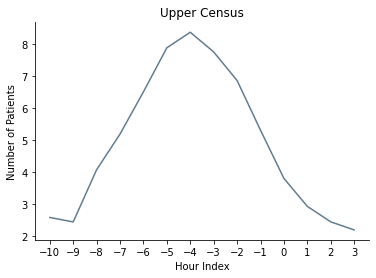

In [33]:
plot_census(lower_census,'upper_census')

# Q4

In [36]:
### Generate regression data
reg_data = data.copy()
### Generate dummies, need to exclude one physician to avoid multicolinearity
### If all dummies equal to 0, then it is Teresa
list_of_phys = list(data['phys_name'].unique())[:-1]
for phy in list_of_phys:
    reg_data[phy] = reg_data['phys_name'].apply(lambda x: 1 if x == phy else 0)
reg_data.dropna(inplace=True)

In [37]:
### Regression
Y = reg_data['xb_lntdc']
X = reg_data[list_of_phys+['ed_hour']] 
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()

In [38]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               xb_lntdc   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     1.453
Date:                Sat, 14 Nov 2020   Prob (F-statistic):             0.0281
Time:                        06:52:32   Log-Likelihood:                -3992.8
No. Observations:                8824   AIC:                             8074.
Df Residuals:                    8780   BIC:                             8385.
Df Model:                          43                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0381      0.035     29.937      0.000       0.970       1.106
Andrew         0.0308      0.042      0.730      0.466      -0.052       0.113
John           0.0851      0.043      1.980      0.048       0.001       0.169
Hillary        0.1391      0.044      3.169      0.002       0.053       0.225
Abraham        0.1037      0.043      2.409      0.016       0.019       0.188
Victoria       0.2637      0.272      0.970      0.332      -0.269       0.796
Grover         0.0797      0.044      1.809      0.070      -0.007       0.166
Martin         0.0853      0.040      2.116      0.034       0.006       0.164
James          0.0642      0.046      1.397      0.162      -0.026       0.154
Chester        0.0951      0.049      1.922      0.055      -0.002       0.192
Ronald         0.0549      0.045      1.214      0.225      -0.034       0.143
Gerald         0.0682      0.039      1.748      0.081      -0.008       0.145
Bill           0.0844      0.042      2.018      0.044       0.002       0.166
Franklin       0.0826      0.044      1.891      0.059      -0.003       0.168
Barack         0.0432      0.042      1.040      0.298      -0.038       0.125
Benjamin       0.0887      0.041      2.182      0.029       0.009       0.168
Diana          0.0416      0.040      1.034      0.301      -0.037       0.120
Lyndon         0.0702      0.043      1.619      0.106      -0.015       0.155
Warren         0.0799      0.041      1.969      0.049       0.000       0.159
Jimmy          0.1322      0.044      3.031      0.002       0.047       0.218
Elizabeth      0.0287      0.052      0.548      0.584      -0.074       0.131
William        0.0706      0.045      1.555      0.120      -0.018       0.160
Anne           0.0588      0.044      1.339      0.180      -0.027       0.145
Whoopi         0.0771      0.038      2.006      0.045       0.002       0.152
Virginia       0.0748      0.041      1.831      0.067      -0.005       0.155
Benazir        0.0472      0.044      1.086      0.278      -0.038       0.133
Richard        0.1204      0.048      2.529      0.011       0.027       0.214
Kate           0.0955      0.045      2.143      0.032       0.008       0.183
Jacqueline     0.1504      0.048      3.159      0.002       0.057       0.244
Eleanor        0.1694      0.049      3.471      0.001       0.074       0.265
Woodrow        0.1080      0.044      2.434      0.015       0.021       0.195
Harry          0.0961      0.040      2.420      0.016       0.018       0.174
Katharine      0.1305      0.058      2.242      0.025       0.016       0.245
Herbert        0.0728      0.046      1.590      0.112      -0.017       0.163
Thomas         0.0532      0.085      0.627      0.531      -0.113       0.220
Dwight         0.0326      0.040      0.823      0.411      -0.045       0.110
Ca

In [39]:
### Export latex file for regression
beginningtex = """\\documentclass{report}
\\usepackage{booktabs}
\\begin{document}"""
endtex = "\end{document}"

f = open('reg.tex', 'w')
f.write(beginningtex)
f.write(results.summary().as_latex())
f.write(endtex)
f.close()

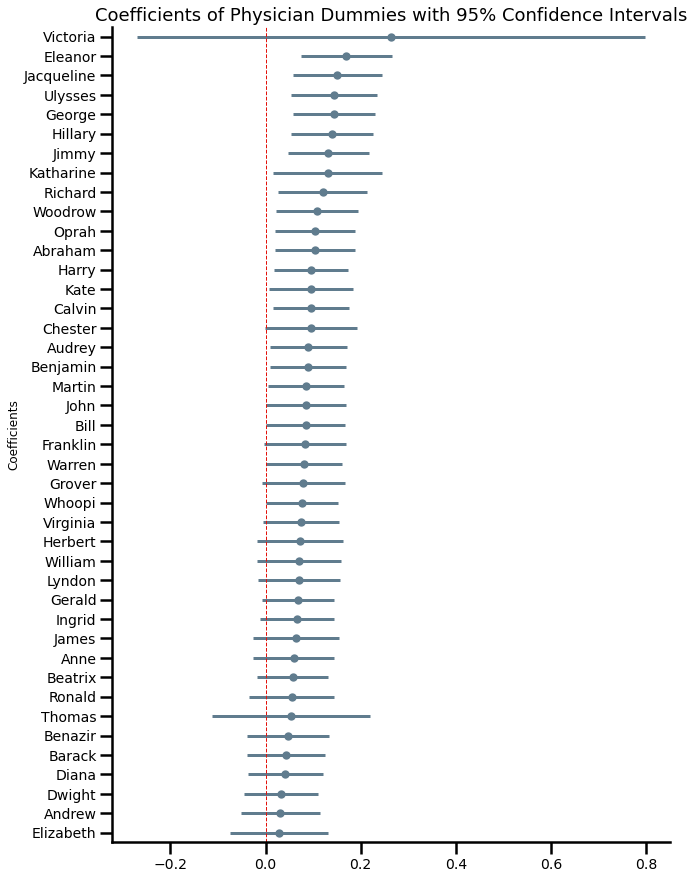

In [40]:
### Plot Coefficient plots for regression
coef_df = pd.DataFrame(results.summary().tables[1].data)
coef_df.columns = coef_df.iloc[0]
coef_df=coef_df.drop(0)
coef_df = coef_df.set_index(coef_df.columns[0])
coef_df.drop(index = ['const','ed_hour'],inplace=True)
coef_df = coef_df.astype(float)
coef_df.sort_values(by=['coef'])
errors = coef_df['coef'] - coef_df['[0.025']
coef_df['errors'] = errors
coef_df = coef_df.sort_values(by=['coef'])
### Plot
variables = list(coef_df.index.values)
coef_df['variables'] = variables
sns.set_context("poster")
fig, ax = plt.subplots(figsize=(10, 15))
# Plot error bar for 95% confidence interval
coef_df.plot(x='variables', y='coef', kind='barh',
             ax=ax, color='none', fontsize=14, 
             ecolor='#607c8e',capsize=0,
             xerr='errors', legend=False)
# Set title & labels
plt.title('Coefficients of Physician Dummies with 95% Confidence Intervals',fontsize=18)
ax.set_ylabel('Coefficients',fontsize=12)
ax.set_xlabel('',fontsize=12)

# Plot Coefficients
ax.scatter(y=pd.np.arange(coef_df.shape[0]), 
           marker='o', s=40, 
           x=coef_df['coef'], color='#607c8e')

# Line to define zero on the x-axis
ax.axvline(x=0, linestyle='--', color='#e3120b', linewidth=1)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('q4.png', dpi=600, format='png')
plt.show()